# Author : Kartik B Bhargav

***
## Triplet networks & one-shot learning

I worked on the Omniglot data set with the same task but extend it to triplet networks, I also compared our model performance under different triplet selection method.

### Import packages and mount data
Before everything, we need to import packages and mount data.

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [0]:
import tensorflow as tf
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances

from numpy import *
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout,Concatenate, BatchNormalization
from tensorflow.keras.layers import ReLU, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [0]:
# mount the data needed to drive folder so we can use them in colab
from google.colab import drive
!mkdir drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
PATH = os.path.join("drive","My Drive","data_DL_practical")
print(os.path.exists(PATH), "exists")

with open(os.path.join(PATH, "omniglot_train.p"), "rb") as f:
    (X_train, c_train) = pickle.load(f)

with open(os.path.join(PATH, "omniglot_test.p"), "rb") as f:
    (X_test, c_test) = pickle.load(f)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("")
print("training alphabets")
print([key for key in c_train.keys()])
print("test alphabets:")
print([key for key in c_test.keys()])

True exists
X_train shape: (964, 20, 105, 105)
X_test shape: (659, 20, 105, 105)

training alphabets
['Braille', 'Anglo-Saxon_Futhorc', 'Tifinagh', 'Grantha', 'Burmese_(Myanmar)', 'Mkhedruli_(Georgian)', 'Latin', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Malay_(Jawi_-_Arabic)', 'Early_Aramaic', 'Korean', 'Japanese_(hiragana)', 'Armenian', 'Cyrillic', 'Hebrew', 'Syriac_(Estrangelo)', 'Japanese_(katakana)', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'N_Ko', 'Alphabet_of_the_Magi', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Greek', 'Bengali', 'Tagalog', 'Futurama', 'Arcadian', 'Gujarati', 'Asomtavruli_(Georgian)', 'Sanskrit']
test alphabets:
['ULOG', 'Atemayar_Qelisayer', 'Ge_ez', 'Gurmukhi', 'Tengwar', 'Keble', 'Malayalam', 'Oriya', 'Kannada', 'Mongolian', 'Angelic', 'Atlantean', 'Syriac_(Serto)', 'Aurek-Besh', 'Avesta', 'Glagolitic', 'Sylheti', 'Tibetan', 'Manipuri', 'Old_Church_Slavonic_(Cyrillic)']


### Task 2.1: Build  the triplet network 

We will define a triplet Network for use with the Omniglot dataset. Each branch of the triplet  is a "convnet" model that transforms data to an embeddings space.

In [0]:
X_train[0].shape

(20, 105, 105)

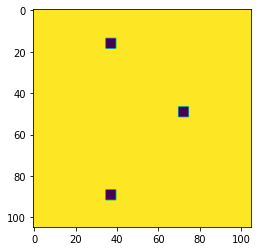

In [0]:
plt.imshow(X_train[1][0])
plt.show()

In [0]:
# define a convnet model to transforms data to an embeddings space. 
def generate_convnet():
  input_shape = (105, 105, 1)
  convnet = Sequential(name='convnet_model')

  convnet.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
  convnet.add(MaxPooling2D())
  convnet.add(BatchNormalization())
  convnet.add(Dropout(0.25))

  convnet.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4)))
  convnet.add(MaxPooling2D())
  convnet.add(BatchNormalization())
  convnet.add(Dropout(0.25))

  convnet.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
  convnet.add(MaxPooling2D())
  convnet.add(BatchNormalization())
  convnet.add(Dropout(0.25))

  convnet.add(Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
  convnet.add(Flatten())
  convnet.add(BatchNormalization())
  convnet.add(Dropout(0.25))
  
  convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))
  convnet.add(Reshape((1,4096)))
  convnet.summary()
  return convnet

In [0]:
# define a Triplet network
def generate_triplet_network():
# The anchor, positive, negative image are merged together, as the input of the triplet network, then got split to get each one's neural codes.
  generated = Input(shape=(3,105, 105,1), name='input')

  anchor  = Lambda(lambda x: x[:,0])(generated)
  pos     = Lambda(lambda x: x[:,1])(generated)
  neg     = Lambda(lambda x: x[:,2])(generated)

  convnet = generate_convnet()

  anchor_embedding = convnet(anchor)
  pos_embedding = convnet(pos)
  neg_embedding = convnet(neg)

# merge the anchor, positive, negative embedding together, 
# let the merged layer be the output of triplet network

# === COMPLETE CODE BELOW ===
  triple = Concatenate(axis=1)([anchor_embedding, pos_embedding, neg_embedding])
  triplet_net = Model(inputs=generated, outputs=triple)
  triplet_net.compile(loss=triplet_loss, optimizer='adam')

  triplet_net.summary()
  return triplet_net

### Task 2.2: Define triplet loss

You can find the formula of the triplet loss function in our lecture note. When training our model, make sure the network achieves a smaller loss than the margin and the network does not collapse all representations to zero vectors. 

In [0]:
# Notice that the ground truth variable is not used for loss calculation. 
# It is used as a function argument to by-pass some Keras functionality.
# This is because the network structure already implies the ground truth for the anchor image with the "positive" image.
import tensorflow as tf

def triplet_loss(ground_truth, network_output):

    anchor, positive, negative = tf.split(network_output, num_or_size_splits=3, axis=1)
            
    alpha=0.2
    # === COMPLETE CODE BELOW ===

    distance_anchor_positive = K.sum(K.square(positive - anchor), axis=(-1, -2))
    distance_anchor_negative = K.sum(K.square(negative - anchor), axis=(-1, -2))

    loss = K.maximum(distance_anchor_positive - distance_anchor_negative + alpha, 0)

    return loss

### Task 2.3: Select triplets for training

#### Different  selection method

We have two different options for the triplet selection method, and we will compare the model performance under these two methods after building our model.

(1) Random  triplets selection, including the following steps:
* Pick one random class for anchor
* Pick two different random picture for this class, as the anchor and positive images
* Pick another class for Negative, different from anchor_class
* Pick one random picture from the negative class.

(2) Hard triplets selection. For easy implement, for a picked anchor, positive pair, we will choose the hardest negative to form a hard triplet, that means, after picking an anchor, positive image, we will choose the negative image which is nearest from anchor image from a negative class, ie: "- d(a,n)"  can get the maximum value. The whole process including the following steps:
* Pick one random class for anchor
* Pick two different random picture for this class, as an anchor and positive images
* Pick another class for negative, different from anchor_class
* Pick one hardest picture from the negative class.


In [0]:
# Notice that the returned  1 * np.zeros(batch_size) is to by-pass some Keras functionality, corresponding to ground_truth in tripletloss
# We use a variable hard_selection to control which method we are going to use. If we set hard_selection == False, we will select triplets random,If we set the variable hard_selection == True, we will select hard triplets.

# === COMPLETE CODE BELOW === 
def get_batch(triplet_net, batch_size, X, hard_selection=False):
    
    #extract convolutional base from triplet net
    convnet = triplet_net.get_layer("convnet_model")

    while True:
        
        n_classes, n_examples, w, h = X.shape
        triplets=[]

        for i in range(batch_size):
            triplet = [[],[],[]]
            #Pick one random class for anchor
            anchor_class = np.random.randint(0, n_classes)

            #Pick two different random pics for this class => idx_A and idx_P
            [idx_anchor,idx_positive] = np.random.choice(n_examples, size=2, replace=False)

            #Pick another class for negative, different from anchor_class
            # === COMPLETE CODE BELOW === 
            negative_class = (anchor_class + np.random.randint(1, n_classes)) % n_classes

            if not hard_selection:
                #Pick a random pic from this negative class => N

                # === COMPLETE CODE BELOW ===   
                idx_negative = np.random.choice(n_examples)

            else:
                #Pick a hardest pic from this negative class => N
                # === COMPLETE CODE BELOW === 
                                
                anchor_image = convnet.predict(X[anchor_class, idx_anchor].reshape((1, w,h,1)))[:,0]
                negative_image = convnet.predict(X[negative_class].reshape((n_examples, w,h,1)))[:,0]             
                distances = euclidean_distances(anchor_image, negative_image)[0]
                idx_negative = np.argmin(distances) 
                
            triplet[0] = X[anchor_class][idx_anchor].reshape(w, h, 1)
            triplet[1] = X[anchor_class][idx_positive].reshape(w, h, 1)
            triplet[2]=  X[negative_class][idx_negative].reshape(w, h, 1)
            triplets.append(triplet)

        yield np.array(triplets), 1 * np.zeros(batch_size)


### Task 2.4: One-shot learning with different selection method

Function "make_oneshot_task" that can randomly setup such a one-shot task from a given test set (if a language is specified, using only classes/characters from that language), i.e. it will generate N pairs of images, where the first image is always the test image, and the second image is one of the N reference images. The pair of images from the same class will have target 1, all other targets are 0.

The function "test_oneshot" will generate a number (k) of such one-shot tasks and evaluate the performance of a given model on these tasks; it reports the percentage of correctly classified test images

In "test_oneshot", you can use embeddings extracted from the triplet network with L2-distance to evaluate one-shot learning. i.e. for a given one-shot task, obtain embeddings for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

*HINT you can re-use some code from practice 4b.4*

In [0]:
def make_oneshot_task(N, X, c, language=None):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""

    n_classes, n_examples, w, h = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))

    if language is not None:
        low, high = c[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = np.random.choice(range(low,high), size=(N,), replace=False)
    else:  # if no language specified just pick a bunch of random letters
        categories = np.random.choice(range(n_classes), size=(N,), replace=False)
            
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, 1)

    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, 1)

    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    
    pairs = [test_image, support_set]
    return np.array(pairs), np.array(targets)


In [0]:
def test_oneshot(triplet_net, X, num, c_num):
    # === COMPLETE CODE BELOW ===     
    convnet_model = triplet_net.get_layer("convnet_model")
  
    num_correct=0

    for j in range(num):
      twoimages, targets = make_oneshot_task(2, X, c_num)
      test_conv = convnet_model.predict (twoimages[np.newaxis, 0, 0])[:,0]
      pred_conv=convnet_model.predict(twoimages[1])[:,0]
      dist=euclidean_distances(test_conv, pred_conv)[0]

      if np.argmin(dist)  == np.argmax(targets):
        num_correct = num_correct + 1

    percent_correct = (num_correct/num) * 100.0

    return percent_correct

In [0]:
def train_selection(triplet_net, X_train, hard_selection, batch_size=64, steps_per_epoch=10, epochs=1):
  triplet_net.fit(get_batch(triplet_net, batch_size, X_train, hard_selection), 
                  steps_per_epoch=steps_per_epoch, 
                  epochs=epochs)

With different triplets selecting method (random and hard), we will train our model and evaluate the model by one-shot learning accuracy.

* You need to explicitly state the accuracy under different  triplets selecting method
* When evaluating model with test_oneshot function, you should evaluate on 20 way one-shot task, and set the number (k) of evaluation one-shot tasks to be 250, then calculate the average accuracy


#### Evaluate one-shot learning with  random triplets selection

In [0]:
# hard_selection == False, selcet triplets randomly
# Train our model and evaluate the model by one-shot learning accuracy.
triplet_net = generate_triplet_network()

num=250
loops = 10
best_acc = 0

for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    # === ADD CODE HERE ===
    train_selection(triplet_net, X_train, hard_selection = False)
    test_accuracy = test_oneshot(triplet_net, X_test, num, c_test)

    if (test_accuracy > best_acc):
      print("Best Accuracy ({})".format(test_accuracy))
      best_acc=test_accuracy
    else:
      print ("Accuray has reached saturation")

print("Best Accuracy {}".format(best_acc))

Model: "convnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 128)     

#### Evaluate one-shot learning with  hard triplets selection

In [0]:
# hard_selection == True, hard triple selection
# Train our model and evaluate the model by one-shot learning accuracy.
triplet_net = generate_triplet_network()

num=250
loops = 10
best_acc = 0

for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    # === ADD CODE HERE ===
    train_selection(triplet_net, X_train, hard_selection = True)
    test_accuracy = test_oneshot(triplet_net, X_test, num, c_test)

    if (test_accuracy > best_acc):
      print("Best Accuracy ({})".format(test_accuracy))
      best_acc=test_accuracy
    else:
      print ("Accuray has reached saturation")

print("Best Accuracy {}".format(best_acc))

Model: "convnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 21, 128)     